<a href="https://colab.research.google.com/github/kyuwoncho/EDA/blob/main/DASK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DASK 설치

In [ ]:
#전체 설치
!pip install "dask[complete]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#부분 설치
!pip install "dask[array]"
!pip install "dask[dataframe]"
!pip install "dask[diagnostics]"
!pip install "dask[distributed]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# DAG 시각화 설치
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# DASK 불러오기

In [ ]:
#Redshift 연결 정보
username = 'dataiger'
password = 'dataiger'
host = 'dataiger-redshift:5439'
database = 'dataiger'

connection_string = f'postgresql://{username} : {password}@{host}/{database}'

In [ ]:
# DB데이터 불러오기
import dask.dataframe as dd

df = dd.read_sql_table(con = connection_string,
                       schema = '스키마명',
                       table_name = '테이블명',
                       index_col = '인덱스로 설정할 컬럼명',
                       columns = ['컬럼1','컬럼2'],
                       npartitions  = 10)

# S3와 HDFS 데이터 불러오기

- 아마존의 s3와 하둡 파일 시스템에서도 데이터를 쉽게 불러올 수 있다.
- s3 파일 경로와 HDFS 파일 경로를 입력해주면 쉽게 불러올 수 있다.

In [ ]:
# s3
s3_data = dd.read_csv('s3://bucket/path/*.csv', dtype = dtypes, usecols = usecols)

#HDFS
hdfs_data = dd.read_csv('hdfs://filepath/*.csv', dtype = dtypes, usecols = usecols )

- dtype과 usecols 매개변수는 사용하지 않아도 무방 BUT DASK는 기본적으로 데이터 타입이 중요 > error를 내지 않기 위해서 명시적으로 타입을 지정해 줄 수 있음
- 사용할 컬럼ㅇ르 명시적으로 지정하는 기능 지원

# Parquet 데이터 불러오기

- DASK와 함께 parquet 파일을 사용하기 위해서는 fastparquet or pyarrow 라이브러리 설치

In [ ]:
# 라이브러리 설치
!pip install fastparquet
!pip install pyarrow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 28.7 MB/s 
     |████████████████████████████████| 1.6 MB 78.0 MB/s 


In [ ]:
#parquet 데이터 불러오기
parquet_data = dd.read_parquet('*.parquet')


In [ ]:
# S3 parquet 불러오기 
s3_parquet_data = dd.read_parquet('s3://bucket/path/*.parquet')

In [ ]:
# HDFS parquet 불러오기 
hdfs_parquet_data = dd.read_parquet('hdfs://filepath/*.parquet')​

# 복잡한 DAG 생성

In [ ]:
import dask.delayed as delayed
from dask.diagnostics import ProgressBar

In [ ]:
def add_two(x):
  return x+2

def sum_two_numbers(x,y):
  return x+y

def multiply_four(x):
  return x*4

data = [1,5,8,10]

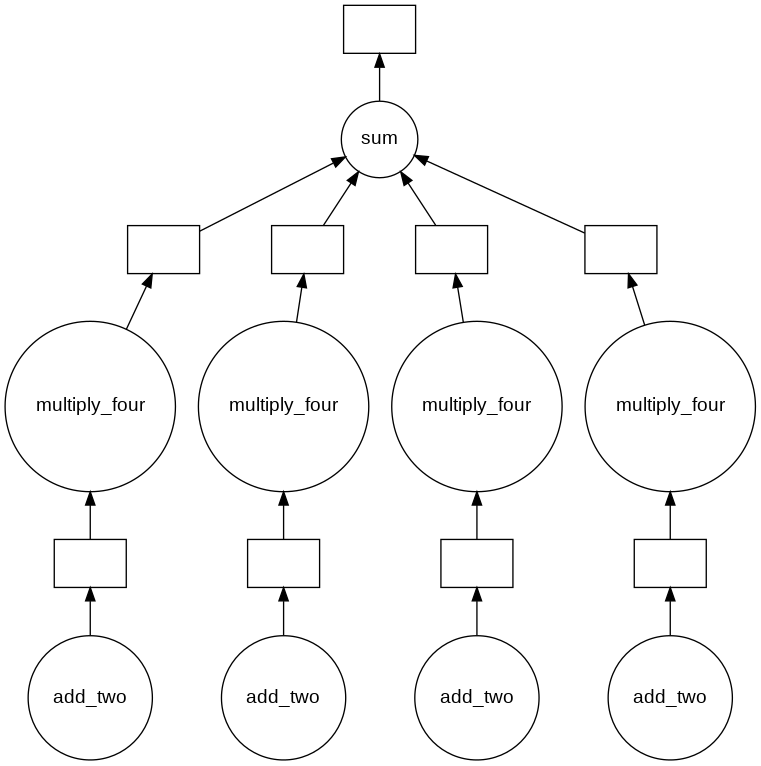

In [ ]:
step1 = [delayed(add_two)(i) for i in data]
step2 = [delayed(multiply_four)(j) for j in step1]
total = delayed(sum)(step2)
total.visualize()

- 계층 추가

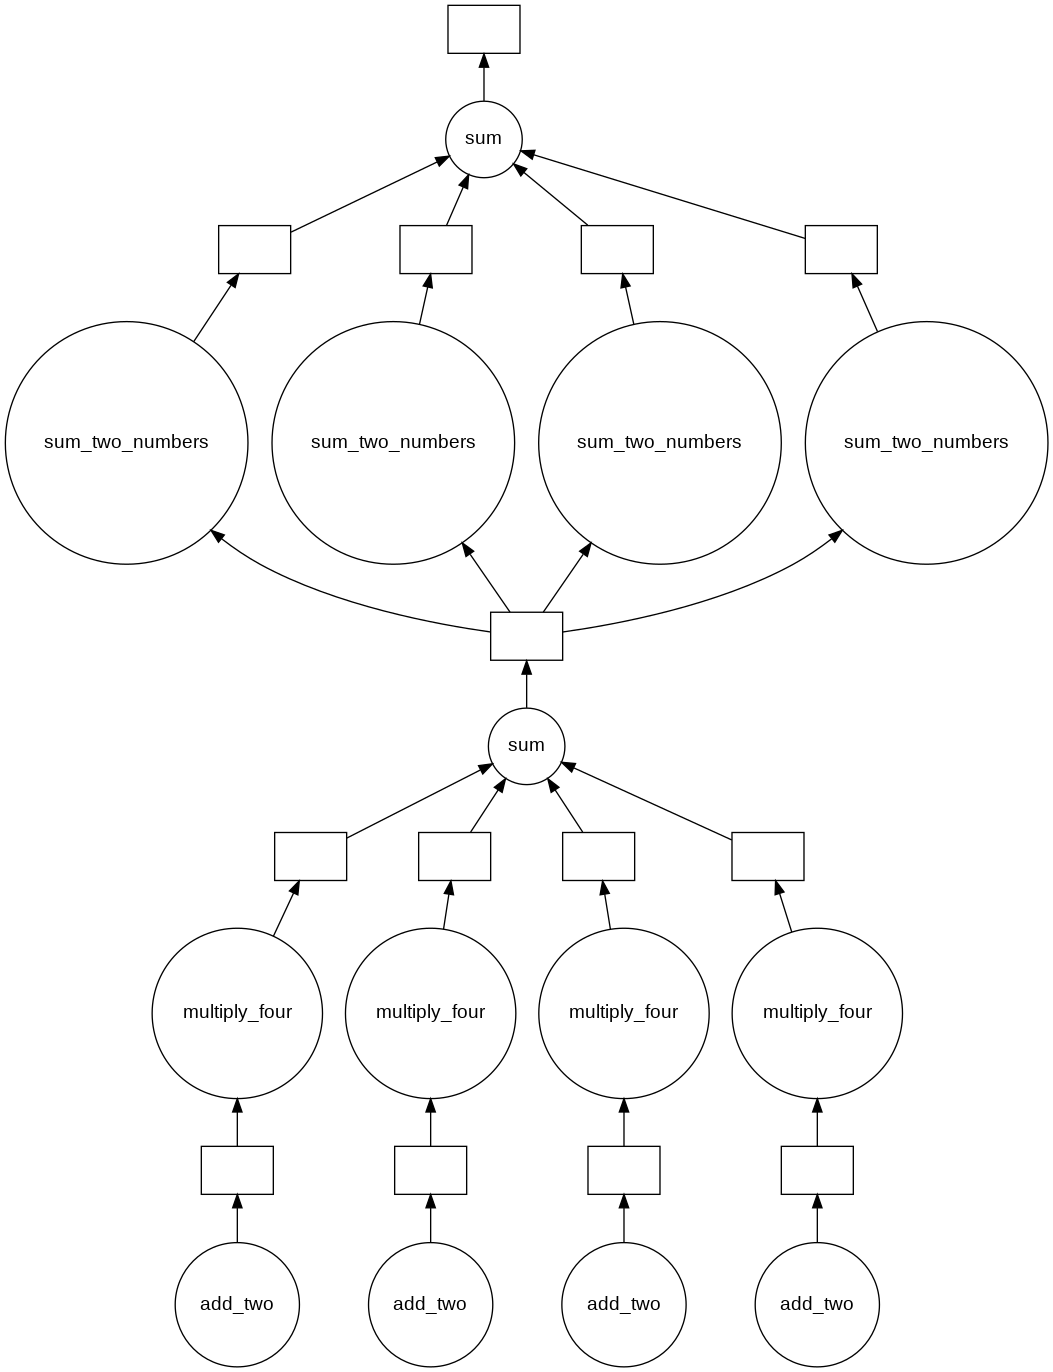

In [ ]:
data2 = [delayed(sum_two_numbers)(k, total) for k in data]
total2 = delayed(sum)(data2)
total2.visualize()

# compute() vs persist()

[########################################] | 100% Completed |  0.1s
536


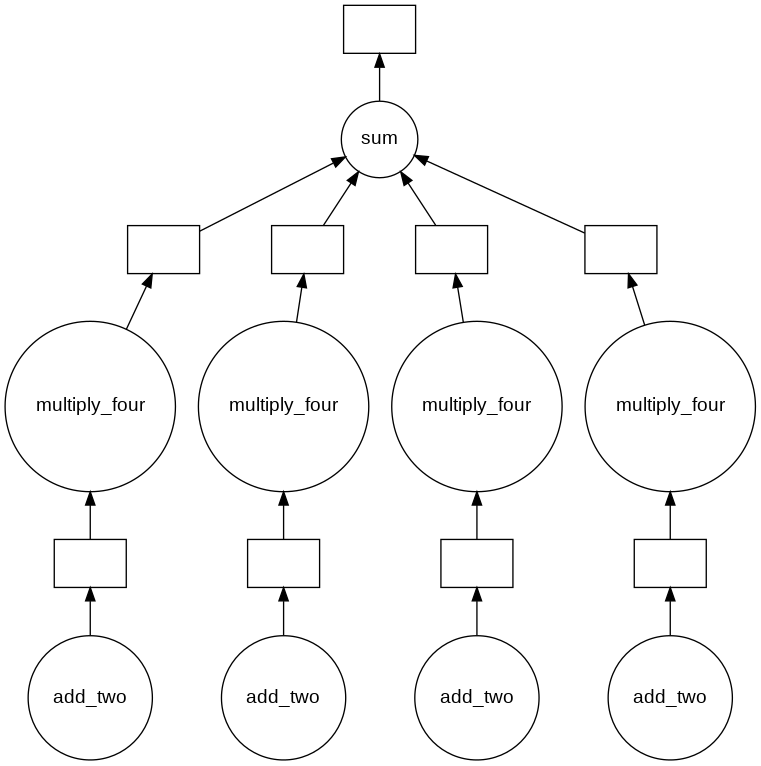

In [ ]:
with ProgressBar():
  print(total2.compute())

total.visualize()

compute()를 사용하면 536의 연산 결과를 도출합니다. 하지만 DAG는 유지가 됩니다.

지연 객체에서 compute 메서드를 호출할 때마다 536이라는 결과를 도출하기 위해서 전체 DAG를 단계적으로 실행합니다.

만약에 실무에서 반복해서 사용되는 결과라고 가정했을 때, 해당 연산을 계속해서 반복하게 됩니다.

이를 효율적으로 사용하기 위해서 persist를 사용합니다.

[########################################] | 100% Completed |  0.1s
Delayed('sum-4b75febc-9110-4aab-af90-a539a337146c')


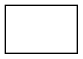

In [ ]:
with ProgressBar() :
    persisted_data = total2.persist()
    print(persisted_data)
persisted_data.visualize()

 
위 코드처럼 persist 메서드를 사용하면 결과를 도출하지는 않지만 지연 객체를 생성하는데, DAG가 단일 결과를 얻었습니다.

자주 사용하게 되는 연산이라면 이처럼 중간 결과를 유지하는(persist)것이 효율적일 것입니다.

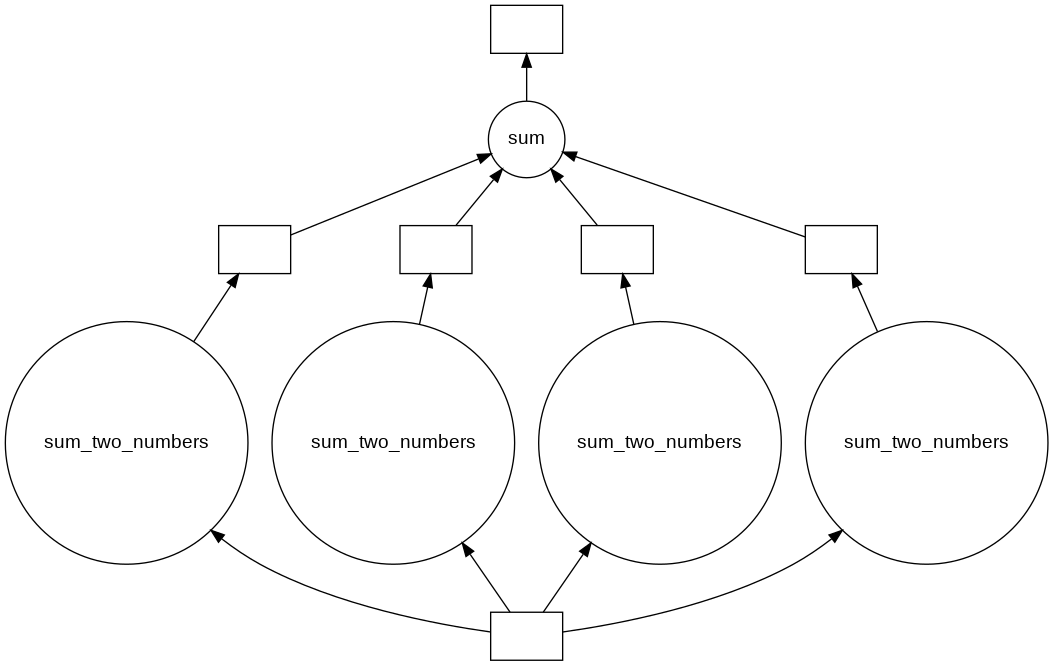

In [ ]:
data3 = [delayed(sum_two_numbers)(1,persisted_data) for l in data]
total3 = delayed(sum)(data3)
total3.visualize()

# Dask의 Dataframe

In [ ]:
import urllib
import tarfile

In [ ]:
#뉴욕에서 출발하는 항공편 데이터 다운로드
url = "https://storage.googleapis.com/dask-tutorial-data/nycflights.tar.gz"
filename, headers = urllib.request.urlretrieve(url, './nycflights.tar.gz')

In [ ]:
# 압축 해제 코드
with tarfile.open(filename, mode = 'r:gz') as flights:
  flights.extractall('data/')

In [ ]:
import dask.dataframe as dd

df = dd.read_csv('./data/nycflights/*.csv', parse_dates = {'Date' : [0,1,2]})

In [ ]:
df.head(5)

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [ ]:
df = dd.read_csv('./data/nycflights/*.csv',
                 parse_dates = {'Data' : [0,1,2]},
                 dtype = {'CRSElapsedTime' : 'float64',
                          'TailNum':'object'})

# DASK와 Keras 연결

In [ ]:
df_train = df[['CRSDepTime',  'CRSArrTime', 'Cancelled']]

- 출발과 도착시간을 통해 취소여부에 대해 예측하는 모델

In [ ]:
with ProgressBar():
  print(df_train.isnull().sum().compute())

[########################################] | 100% Completed |  3.2s
CRSDepTime    0
CRSArrTime    0
Cancelled     0
dtype: int64


In [ ]:
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
model = Sequential()
# input_dim=df_train.iloc[:, :-1] : Cancelled 컬럼을 제외한 dimension 
model.add(Dense(20, input_dim=df_train.iloc[:, :-1].shape[1], activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='sgd',)

In [ ]:
model.fit(df_train.iloc[:, :-1].compute(), df_train.iloc[:, -1].compute(),
          batch_size=256,
          epochs=10
         )

Epoch 1/10
10203/10203 [==============================] - 9s 869us/step - loss: 8.0859
Epoch 2/10
10203/10203 [==============================] - 9s 879us/step - loss: 0.1247
Epoch 3/10
10203/10203 [==============================] - 9s 917us/step - loss: 0.1247
Epoch 4/10
10203/10203 [==============================] - 9s 867us/step - loss: 0.1247
Epoch 5/10
10203/10203 [==============================] - 10s 937us/step - loss: 0.1247
Epoch 6/10
10203/10203 [==============================] - 9s 863us/step - loss: 0.1247
Epoch 7/10
10203/10203 [==============================] - 9s 869us/step - loss: 0.1247
Epoch 8/10
10203/10203 [==============================] - 9s 867us/step - loss: 0.1247
Epoch 9/10
10203/10203 [==============================] - 9s 863us/step - loss: 0.1247
Epoch 10/10
10203/10203 [==============================] - 9s 867us/step - loss: 0.1247
